<a href="https://colab.research.google.com/github/agung-madani/Stock_JKSE_Prediction_using_Numerical_and_Textual_Analysis/blob/main/Stock_JKSE_Prediction_using_Numerical_and_Textual_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.10.12


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
!pip install lightning pytorch-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 24.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 

In [21]:
!pip install --upgrade optuna==3.4.0 torch==2.2.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: optuna
    Found existing installation: optuna 3.6.1
    Uninstalling optuna-3.6.1:
      Successfully uninstalled optuna-3.6.1


In [22]:
!pip install --upgrade matplotlib==3.4.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.4.3-cp310-cp310-linux_x86_64.whl size=10439721 sha256=e822fc001419f4e99a43f07507daa7f98098b7671df99703daede9347d7c7cca
  Stored in directory: /root/.cache/pip/wheels/71/af/e4/d399b616d3e7ae88374c2ebab2d5d3ecf776a3590d4f5f768f
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.0.0 requires matplotlib>=3.7.1, but you have matplotlib 3.4.3 which is incompatible.
mizani 0.9.3 requires matplotlib>=3.5.0, but you have matplotlib 3.4.3 which is incompatible.
plotnine 0.12.4 requires matplotli

In [23]:
exit()

In [58]:
import numpy as np
import pandas as pd
import zipfile
import shutil
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner
from sklearn.metrics import r2_score
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, MAPE, RMSE, QuantileLoss, MASE, SMAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile


In [2]:
#read the data
data_news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SparksFoundation/data_news.csv')
data_news

,judul_berita,tanggal_publikasi,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,150 Satpol PP personnel working at Kampung Mel...,2020-01-01,0.309587,0.091429,0.9828,0.053,0.844,0.103
1,ready-to-eat meals for evacuees Cipinang Melay...,2020-01-02,0.344259,0.064769,0.9186,0.075,0.815,0.109
2,bank dki ancol socialization for mobile point ...,2020-01-03,0.367960,0.104343,0.9753,0.088,0.773,0.139
3,West Jakarta SDA Sub-Department has five mobil...,2020-01-04,0.272727,0.092424,0.9559,0.047,0.842,0.111
4,Sudin LH West Jakarta Collar 360 Community Ser...,2020-01-05,0.539815,0.071296,0.9682,0.046,0.843,0.112
...,...,...,...,...,...,...,...,...
360,burning down the houses of Tanjung Priok resid...,2020-12-27,0.290972,-0.076389,0.8074,0.018,0.866,0.116
361,pbkl KPKP service restocking 1700 white snappe...,2020-12-28,0.535463,0.255668,0.9855,0.000,0.850,0.150
362,DKI Provincial Government implements strict co...,2020-12-29,0.406742,0.103939,-0.4588,0.071,0.873,0.056
363,Ancol attends virtual educational tour breakin...,2020-12-30,0.309242,0.055606,0.9552,0.025,0.854,0.121


In [3]:
data_news.drop(['kategori','periode_data','jam_publikasi'], axis = 1, inplace=True)
data_news

,judul_berita,tanggal_publikasi
0,1.048 Pesilat Berlaga di Kejuaran Antar Pelaja...,1/31/2020
1,UP JSC Terus Kembangkan Aplikasi JAKI,1/31/2020
2,Peragaan Busana Digelar di Kereta MRT,1/31/2020
3,"Cegah Kecelakaan, Pembatas Jalan Dipasang di J...",1/31/2020
4,Sudin Dukcapil Jakpus Kebut Pembuatan KIA di S...,1/31/2020
...,...,...
9002,PT MRT Jakarta Apresiasi Peluncuran Uang Khusu...,8/17/2020
9003,Wali Kota Jakut Ajak Warga Wujudkan Semangat P...,8/17/2020
9004,Sudinsos Jaktim Salurkan Bantuan untuk Korban ...,8/17/2020
9005,Petugas Gabungan Ajak Pengendara di Jakarta Ti...,8/17/2020


In [4]:
time_data = data_news['tanggal_publikasi'].str.contains(r'\d{1,2}:\d{2}')

# This will return a Series of True/False values. True if the row contains time data, False otherwise.
# You can print the rows that contain time data like this:

print(data_news[time_data])

                                           judul_berita tanggal_publikasi
4500  Tak Gunakan Masker, 10 Warga Disanksi Bersihka...             15:43


In [5]:
data_news = data_news.drop(4500)

In [6]:
data_news['tanggal_publikasi'] = pd.to_datetime(data_news['tanggal_publikasi'])

In [7]:
data_news['judul_berita'] = data_news.groupby(['tanggal_publikasi']).transform(lambda x : ' '.join(x))
data_news = data_news.drop_duplicates()
data_news = data_news.sort_values(by='tanggal_publikasi', ascending=True).reset_index(drop=True)
data_news

,judul_berita,tanggal_publikasi
0,150 Personel Satpol PP Dikerahkan ke Lokasi Ba...,2020-01-01
1,Makanan Siap Saji Dibagikan Pada Pengungsi di ...,2020-01-02
2,Bank DKI dan Ancol Sosialisasikan Penggunaan M...,2020-01-03
3,Sudin SDA Jakbar Kerahkan Lima Pompa Mobile At...,2020-01-04
4,Sudin LH Jakbar Kerahkan 360 Petugas Dalam Ker...,2020-01-05
...,...,...
360,Kebakaran di Permukiman Warga Tanjung Priok Be...,2020-12-27
361,PBKL Dinas KPKP Restocking 1.700 Benih Kakap P...,2020-12-28
362,Pemprov DKI Terapkan Pengendalian Ketat di Jal...,2020-12-29
363,Ancol Hadirkan Wisata Edukasi Secara Virtual P...,2020-12-30


In [3]:
!pip install sastrawi

In [9]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string

# Assuming data_news is your DataFrame
data_news['judul_berita'] = data_news['judul_berita'].str.lower()

# Remove punctuation
data_news['judul_berita'] = data_news['judul_berita'].str.translate(str.maketrans('', '', string.punctuation))

# Remove stopwords
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()
data_news['judul_berita'] = data_news['judul_berita'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

data_news

,judul_berita,tanggal_publikasi
0,150 personel satpol pp kerah lokasi banjir kam...,2020-01-01
1,makan siap saji bagi ungsi cipinang melayu wal...,2020-01-02
2,bank dki ancol sosialisasi guna mobile point o...,2020-01-03
3,sudin sda jakbar kerah lima pompa mobile atas ...,2020-01-04
4,sudin lh jakbar kerah 360 tugas kerja bakti ra...,2020-01-05
...,...,...
360,bakar mukim warga tanjung priok hasil padam ke...,2020-12-27
361,pbkl dinas kpkp restocking 1700 benih kakap pu...,2020-12-28
362,pemprov dki terap kendali ketat jalan sudirman...,2020-12-29
363,ancol hadir wisata edukasi virtual langgar pro...,2020-12-30


In [11]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [15]:
!pip install deep_translator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 968.0 kB/s eta 0:00:00


In [16]:
from deep_translator import GoogleTranslator
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Assuming data_news is your DataFrame
sia = SentimentIntensityAnalyzer()

# Translate 'judul_berita' to English
data_news['judul_berita'] = data_news['judul_berita'].apply(lambda x: GoogleTranslator(source='indonesian', target='english').translate(x))

# Calculate Subjectivity and Polarity
data_news['Subjectivity'] = data_news['judul_berita'].apply(lambda text: TextBlob(text).sentiment.subjectivity)
data_news['Polarity'] = data_news['judul_berita'].apply(lambda text: TextBlob(text).sentiment.polarity)

# Calculate Compound, Negative, Neutral, and Positive scores
sentiment_scores = data_news['judul_berita'].apply(lambda text: sia.polarity_scores(text))
data_news['Compound'] = sentiment_scores.apply(lambda score_dict: score_dict['compound'])
data_news['Negative'] = sentiment_scores.apply(lambda score_dict: score_dict['neg'])
data_news['Neutral'] = sentiment_scores.apply(lambda score_dict: score_dict['neu'])
data_news['Positive'] = sentiment_scores.apply(lambda score_dict: score_dict['pos'])


In [19]:
data_news.to_csv('/content/drive/MyDrive/Colab Notebooks/SparksFoundation/data_news.csv', index=False)

In [25]:
#read the data
data_stock = pd.read_csv('JKSE.csv')
data_stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,6313.127930,6317.013184,6263.675781,6283.581055,6283.581055,33043700
1,2020-01-03,6306.187012,6323.465820,6287.706055,6323.465820,6323.465820,44625300
2,2020-01-06,6293.499023,6300.436035,6252.634766,6257.402832,6257.402832,41421300
3,2020-01-07,6272.220215,6284.892090,6246.128906,6279.346191,6279.346191,39441600
4,2020-01-08,6248.442871,6250.122070,6218.129883,6225.686035,6225.686035,44622600
...,...,...,...,...,...,...,...
237,2020-12-22,6146.645996,6174.458984,6010.210938,6023.289063,6023.289063,250085200
238,2020-12-23,6061.848145,6104.354980,5853.261230,6008.708984,6008.708984,203528500
239,2020-12-28,6067.000000,6095.007813,5979.904785,6093.554199,6093.554199,180855700
240,2020-12-29,6112.720215,6143.870117,6026.705078,6036.173828,6036.173828,175135000


In [26]:
data_stock['Date'] = pd.to_datetime(data_stock['Date'])
data_news['tanggal_publikasi'] = pd.to_datetime(data_news['tanggal_publikasi'])

# Then, merge the two dataframes on the date columns
result = pd.merge(data_stock, data_news, left_on='Date', right_on='tanggal_publikasi', how='inner')

# Drop the 'tanggal_publikasi' column as it's redundant
result = result.drop(columns=['tanggal_publikasi'])

In [27]:
result

,Date,Open,High,Low,Close,Adj Close,Volume,judul_berita,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2020-01-02,6313.127930,6317.013184,6263.675781,6283.581055,6283.581055,33043700,ready-to-eat meals for evacuees Cipinang Melay...,0.344259,0.064769,0.9186,0.075,0.815,0.109
1,2020-01-03,6306.187012,6323.465820,6287.706055,6323.465820,6323.465820,44625300,bank dki ancol socialization for mobile point ...,0.367960,0.104343,0.9753,0.088,0.773,0.139
2,2020-01-06,6293.499023,6300.436035,6252.634766,6257.402832,6257.402832,41421300,DKI PP Satpol closes New Monggo Mas 5000 takes...,0.382407,0.056229,0.9432,0.070,0.806,0.124
3,2020-01-07,6272.220215,6284.892090,6246.128906,6279.346191,6279.346191,39441600,KPKP service subsidized food distribution in 2...,0.504167,0.194444,0.9201,0.040,0.869,0.091
4,2020-01-08,6248.442871,6250.122070,6218.129883,6225.686035,6225.686035,44622600,"under the Cipinang flyover, plant vegetables i...",0.426032,0.169603,0.8957,0.085,0.785,0.130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2020-12-22,6146.645996,6174.458984,6010.210938,6023.289063,6023.289063,250085200,Madam Atas's six cars burned down the crocodil...,0.485594,0.308721,0.9937,0.005,0.807,0.188
238,2020-12-23,6061.848145,6104.354980,5853.261230,6008.708984,6008.708984,203528500,DKI Provincial Government Launches Jakartaprov...,0.238292,0.115427,0.9666,0.035,0.788,0.177
239,2020-12-28,6067.000000,6095.007813,5979.904785,6093.554199,6093.554199,180855700,pbkl KPKP service restocking 1700 white snappe...,0.535463,0.255668,0.9855,0.000,0.850,0.150
240,2020-12-29,6112.720215,6143.870117,6026.705078,6036.173828,6036.173828,175135000,DKI Provincial Government implements strict co...,0.406742,0.103939,-0.4588,0.071,0.873,0.056


In [33]:
data = result.copy()

In [34]:
# Assuming data is your DataFrame
data.set_index(data.columns[0], inplace=True)

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 242 entries, 2020-01-02 to 2020-12-30
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          242 non-null    float64
 1   High          242 non-null    float64
 2   Low           242 non-null    float64
 3   Close         242 non-null    float64
 4   Adj Close     242 non-null    float64
 5   Volume        242 non-null    int64  
 6   judul_berita  242 non-null    object 
 7   Subjectivity  242 non-null    float64
 8   Polarity      242 non-null    float64
 9   Compound      242 non-null    float64
 10  Negative      242 non-null    float64
 11  Neutral       242 non-null    float64
 12  Positive      242 non-null    float64
dtypes: float64(11), int64(1), object(1)
memory usage: 26.5+ KB


In [36]:
data = data.dropna()
data = data.iloc[:,:]

In [37]:
data.head(3)

,Open,High,Low,Close,Adj Close,Volume,judul_berita,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
Date,,,,,,,,,,,,,
2020-01-02,6313.127930,6317.013184,6263.675781,6283.581055,6283.581055,33043700,ready-to-eat meals for evacuees Cipinang Melay...,0.344259,0.064769,0.9186,0.075,0.815,0.109
2020-01-03,6306.187012,6323.465820,6287.706055,6323.465820,6323.465820,44625300,bank dki ancol socialization for mobile point ...,0.367960,0.104343,0.9753,0.088,0.773,0.139
2020-01-06,6293.499023,6300.436035,6252.634766,6257.402832,6257.402832,41421300,DKI PP Satpol closes New Monggo Mas 5000 takes...,0.382407,0.056229,0.9432,0.070,0.806,0.124


In [38]:
earliest_time = data.index.min()
earliest_time

Timestamp('2020-01-02 00:00:00')

In [39]:
data.min()

Open                                                   3937.63208
High                                                  4123.562012
Low                                                   3911.716064
Close                                                  3937.63208
Adj Close                                              3937.63208
Volume                                                          0
judul_berita    10 kube take part in star hotel bazaar, KPKP s...
Subjectivity                                             0.047619
Polarity                                                -0.062587
Compound                                                  -0.8779
Negative                                                      0.0
Neutral                                                     0.728
Positive                                                    0.043
dtype: object

In [40]:
data_list = []
# tmp_volume = pd.concat([data["Volume"]]*5, ignore_index=True)

for label in data.iloc[:,:5]:

    ts = data[label]

    start_date = min(ts.fillna(method='ffill').dropna().index)
    end_date = max(ts.fillna(method='bfill').dropna().index)

    active_range = (ts.index >= start_date) & (ts.index <= end_date)
    ts = ts[active_range].fillna(0.)

    tmp = pd.DataFrame({'stock_price': ts})
    date = tmp.index

    # tmp['hours_from_start'] = (date - earliest_time).seconds / 60 / 60 + (date - earliest_time).days * 24
    # tmp['hours_from_start'] = tmp['hours_from_start'].astype('int')

    tmp['days_from_start'] = (date - earliest_time).days
    tmp['date'] = date
    tmp['terms'] = label
    # tmp['hour'] = date.hour
    tmp['day'] = date.day
    tmp['day_of_week'] = date.dayofweek
    tmp['month'] = date.month
    tmp['subjectivity'] = data["Subjectivity"]
    tmp['polarity'] = data["Polarity"]
    tmp['compound'] = data["Compound"]
    tmp['negative'] = data["Negative"]
    tmp['neutral'] = data["Neutral"]
    tmp['positive'] = data["Positive"]

    #stack all time series vertically
    data_list.append(tmp)


In [67]:
time_data = pd.concat(data_list).reset_index(drop=True)

# time_data['date'] = pd.to_datetime(time_data['date'])  # convert the date column to datetime
# cutoff_date = pd.to_datetime('2022-04-18')  # define the cutoff date

# time_data = time_data[time_data['date'] >= cutoff_date]  # filter the DataFrame
time_data

,stock_price,days_from_start,date,terms,day,day_of_week,month,subjectivity,polarity,compound,negative,neutral,positive
0,6313.127930,0,2020-01-02,Open,2,3,1,0.344259,0.064769,0.9186,0.075,0.815,0.109
1,6306.187012,1,2020-01-03,Open,3,4,1,0.367960,0.104343,0.9753,0.088,0.773,0.139
2,6293.499023,4,2020-01-06,Open,6,0,1,0.382407,0.056229,0.9432,0.070,0.806,0.124
3,6272.220215,5,2020-01-07,Open,7,1,1,0.504167,0.194444,0.9201,0.040,0.869,0.091
4,6248.442871,6,2020-01-08,Open,8,2,1,0.426032,0.169603,0.8957,0.085,0.785,0.130
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1205,6023.289063,355,2020-12-22,Adj Close,22,1,12,0.485594,0.308721,0.9937,0.005,0.807,0.188
1206,6008.708984,356,2020-12-23,Adj Close,23,2,12,0.238292,0.115427,0.9666,0.035,0.788,0.177
1207,6093.554199,361,2020-12-28,Adj Close,28,0,12,0.535463,0.255668,0.9855,0.000,0.850,0.150
1208,6036.173828,362,2020-12-29,Adj Close,29,1,12,0.406742,0.103939,-0.4588,0.071,0.873,0.056


In [42]:
time_data[['terms','stock_price']].groupby('terms').mean()

,stock_price
terms,
Adj Close,5248.973989
Close,5248.973989
High,5291.328454
Low,5205.944787
Open,5251.628068


In [68]:
max_prediction_length = 1
max_encoder_length = 5
training_cutoff = time_data["days_from_start"].max() - max_prediction_length

training = TimeSeriesDataSet(
    time_data[lambda x: x.days_from_start <= training_cutoff],
    time_idx="days_from_start",
    target="stock_price",
    group_ids=["terms"],
    min_encoder_length=1,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["terms"],
    time_varying_known_reals=["days_from_start","day","day_of_week", "month"],
    time_varying_unknown_reals=['stock_price', 'subjectivity', 'polarity', 'compound', 'negative', 'neutral', 'positive'],
    target_normalizer=GroupNormalizer(
        groups=["terms"], transformation="softplus"
    ),  # we normalize by group
    add_relative_time_idx=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

In [69]:
validation = TimeSeriesDataSet.from_dataset(training, time_data, predict=True, stop_randomization=True)

# create dataloaders for  our model
batch_size = 64
# if you have a strong GPU, feel free to increase the number of workers
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
# train_time_data

In [ ]:
# val_time_data

In [70]:
training.index

,time_first,time_last,time_diff_to_next,index_start,time,count,sequence_id,index_end,sequence_length
0,0,362,1,0,0,363,0,3,6
1,0,362,3,1,1,363,0,4,6
2,0,362,1,2,4,363,0,6,5
3,0,362,1,3,5,363,0,6,4
4,0,362,1,4,6,363,0,7,6
...,...,...,...,...,...,...,...,...,...
1695,0,362,1,1186,333,363,4,1189,4
1696,0,362,1,1186,333,363,4,1190,5
1697,0,362,1,1191,340,363,4,1194,5
1698,0,362,1,1195,347,363,4,1198,4


In [71]:
validation.index

,time_first,time_last,time_diff_to_next,index_start,time,count,sequence_id,index_end,sequence_length
239,0,363,1,239,361,364,0,241,3
481,0,363,1,481,361,364,1,483,3
723,0,363,1,723,361,364,2,725,3
965,0,363,1,965,361,364,3,967,3
1207,0,363,1,1207,361,364,4,1209,3


In [72]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cuda",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.001,
    hidden_size=160,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=160,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 3174.8k


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0026915348039269153
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0026915348039269153
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_70422c68-15d8-4674-b19e-bba70d039a59.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_70422c68-15d8-4674-b19e-bba70d039a59.ckpt


suggested learning rate: 0.0026915348039269153


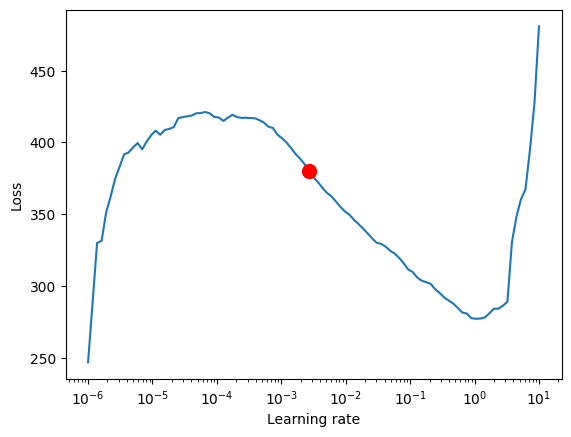

In [73]:
res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [74]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=45,
    accelerator='gpu',
    devices=1,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 3174.8k


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [75]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 20    
3  | prescalers                         | ModuleDict                      | 4.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 104 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.3 M 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 523 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 103 K 
8  | static_context_initia

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 586.509
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 586.509


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 295.028 >= min_delta = 0.0001. New best score: 291.481
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 295.028 >= min_delta = 0.0001. New best score: 291.481


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 103.074 >= min_delta = 0.0001. New best score: 188.407
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 103.074 >= min_delta = 0.0001. New best score: 188.407


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 105.205 >= min_delta = 0.0001. New best score: 83.202
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 105.205 >= min_delta = 0.0001. New best score: 83.202


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 32.806 >= min_delta = 0.0001. New best score: 50.396
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 32.806 >= min_delta = 0.0001. New best score: 50.396


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 18.658 >= min_delta = 0.0001. New best score: 31.738
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 18.658 >= min_delta = 0.0001. New best score: 31.738


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 11.400 >= min_delta = 0.0001. New best score: 20.338
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 11.400 >= min_delta = 0.0001. New best score: 20.338


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 10 records. Best score: 20.338. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 20.338. Signaling Trainer to stop.


In [ ]:
# import pickle

In [ ]:
# # create a new study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_loss_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save study results
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # print best hyperparameters
# print(study.best_trial.params)

In [76]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/lightning_logs/version_1/checkpoints/epoch=25-step=676.ckpt


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [79]:
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu"))

print(f'MAE: {MAE()(predictions.output, predictions.y)}')
print(f'MAPE: {MAPE()(predictions.output, predictions.y)}')
print(f'SMAPE: {SMAPE()(predictions.output, predictions.y)}')
print(f'RMSE: {RMSE()(predictions.output, predictions.y)}')

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MAE: 65.1620101928711
MAPE: 0.010845924727618694
SMAPE: 0.010784999467432499
RMSE: 66.5401382446289


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x250 with 1 Axes>,
 'encoder_variables': <Figure size 700x500 with 1 Axes>,
 'decoder_variables': <Figure size 700x325 with 1 Axes>}

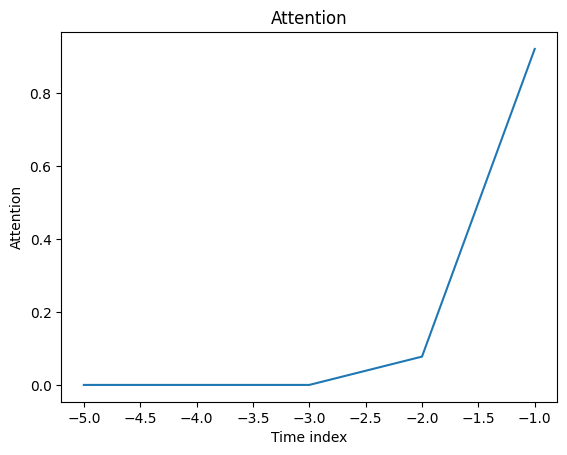

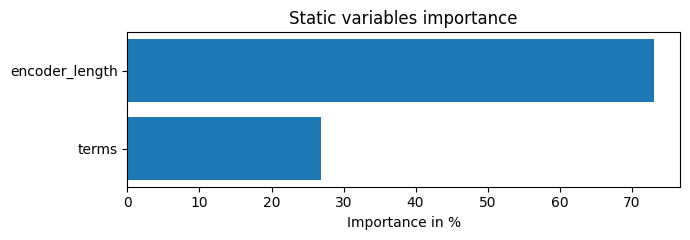

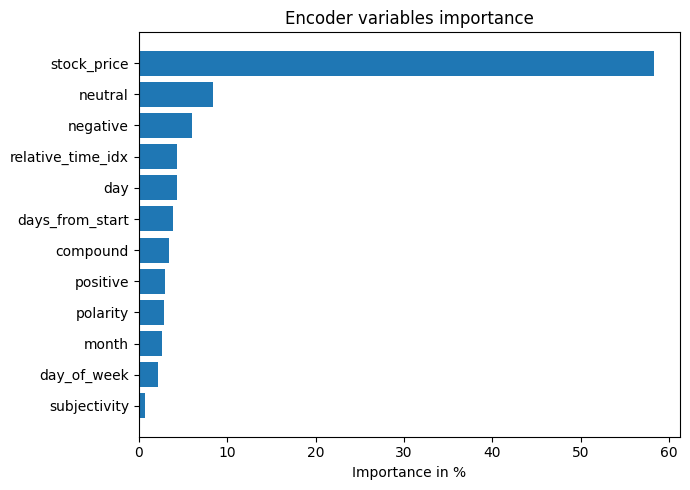

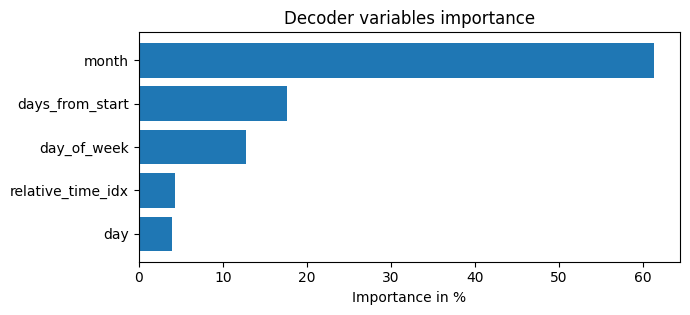

In [78]:
raw_predictions= best_tft.predict(val_dataloader, mode="raw", return_x=True)
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)